# Modeling - Random Forest Classifier

**Obiettivo:** Classificazione IncidentGrade con Random Forest

**Metrica:** Macro F1-Score

**Pipeline:**
1. Caricamento dati
2. Training Random Forest
3. Valutazione e cross-validation
4. Feature importance
5. Salvataggio modello

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pickle
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate con successo!")

Librerie importate con successo!


## 2. Caricamento Dati

In [2]:
print("Caricamento dataset processati...")

X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')['IncidentGrade']
y_test = pd.read_csv('../data/processed/y_test.csv')['IncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribuzione y_train:\n{y_train.value_counts(normalize=True)}")

Caricamento dataset processati...
X_train: (314230, 20)
X_test: (134671, 20)

Distribuzione y_train:
IncidentGrade
BenignPositive    0.485921
FalsePositive     0.301088
TruePositive      0.212990
Name: proportion, dtype: float64


In [3]:
# Encoding target
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

print("Mapping label:")
for i, label in enumerate(le_target.classes_):
    print(f"  {label} -> {i}")

Mapping label:
  BenignPositive -> 0
  FalsePositive -> 1
  TruePositive -> 2


## 3. Training Random Forest

In [4]:
print("Training Random Forest...\n")

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train_encoded)

print("\nTraining completato!")

Training Random Forest...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    2.1s



Training completato!


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.3s finished


## 4. Valutazione

In [5]:
y_pred = model.predict(X_test)

print("=" * 70)
print("PERFORMANCE TEST SET")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(
    y_test_encoded, y_pred,
    target_names=le_target.classes_,
    digits=4
))

accuracy = accuracy_score(y_test_encoded, y_pred)
macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

print(f"\nACCURACY:          {accuracy:.4f}")
print(f"MACRO F1-SCORE:    {macro_f1:.4f} ⭐")

PERFORMANCE TEST SET

Classification Report:
                precision    recall  f1-score   support

BenignPositive     0.6841    0.5392    0.6031     65440
 FalsePositive     0.4965    0.6806    0.5742     40547
  TruePositive     0.4122    0.3953    0.4036     28684

      accuracy                         0.5511    134671
     macro avg     0.5309    0.5384    0.5269    134671
  weighted avg     0.5697    0.5511    0.5519    134671


ACCURACY:          0.5511
MACRO F1-SCORE:    0.5269 ⭐


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    0.2s finished


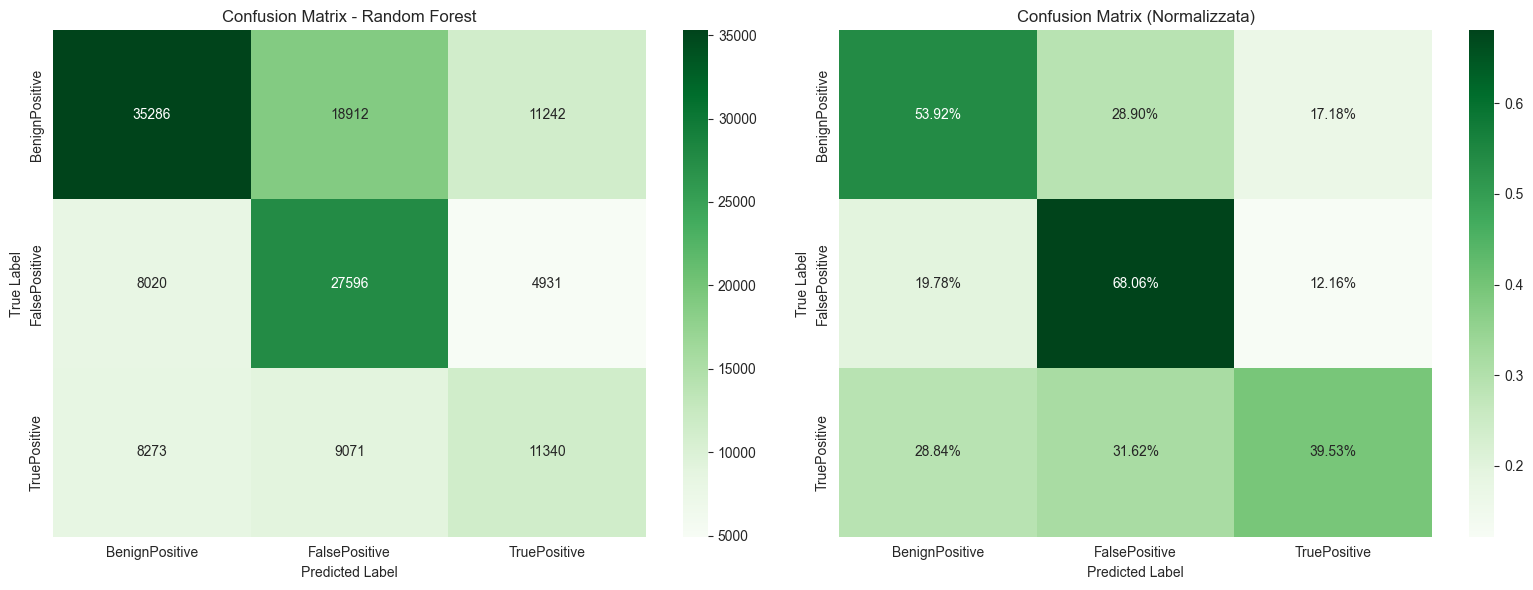

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Forest')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalizzata)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ottieni probabilità di predizione
y_pred_proba = model.predict_proba(X_test)

# Binarizza le label per ROC multi-class (One-vs-Rest)
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calcola ROC curve e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("ROC AUC Scores:")
for i, class_name in enumerate(le_target.classes_):
    print(f"  {class_name}: {roc_auc[i]:.4f}")
print(f"  Micro-average: {roc_auc['micro']:.4f}")


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    0.2s finished


ROC AUC Scores:
  BenignPositive: 0.7246
  FalsePositive: 0.7620
  TruePositive: 0.6954
  Micro-average: 0.7340


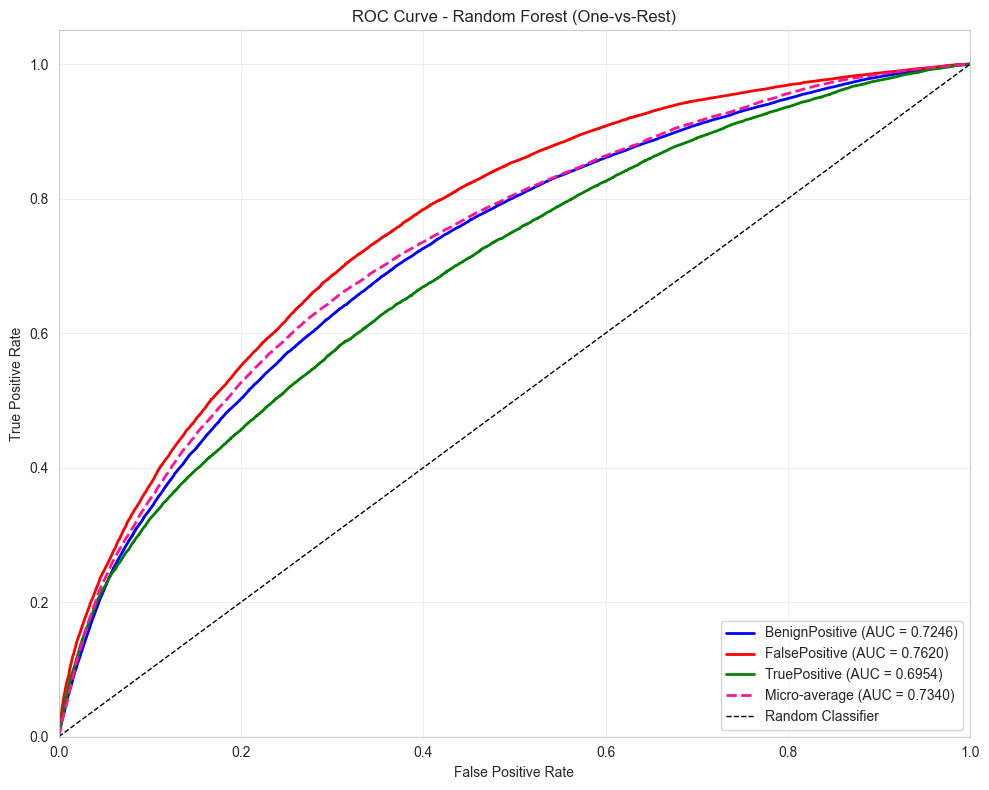

In [9]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{le_target.classes_[i]} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 4.1 ROC Curve (One-vs-Rest)


In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ottieni probabilità di predizione
y_pred_proba = model.predict_proba(X_test)

# Binarizza le label per ROC multi-class (One-vs-Rest)
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calcola ROC curve e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("ROC AUC Scores:")
for i, class_name in enumerate(le_target.classes_):
    print(f"  {class_name}: {roc_auc[i]:.4f}")
print(f"  Micro-average: {roc_auc['micro']:.4f}")


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.2s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    0.2s finished


ROC AUC Scores:
  BenignPositive: 0.7246
  FalsePositive: 0.7620
  TruePositive: 0.6954
  Micro-average: 0.7340


## 5. Cross-Validation

In [11]:
print("Esecuzione 5-Fold Cross-Validation...\n")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    model, X_train, y_train_encoded,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1
)

print(f"Cross-Validation Macro F1 Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMedia:  {cv_scores.mean():.4f}")
print(f"Std:    {cv_scores.std():.4f}")

Esecuzione 5-Fold Cross-Validation...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 172 

Cross-Validation Macro F1 Scores:
  Fold 1: 0.5235
  Fold 2: 0.5234
  Fold 3: 0.5254
  Fold 4: 0.5240
  Fold 5: 0.5239

Media:  0.5240
Std:    0.0007


## 6. Feature Importance

In [12]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Features più importanti:")
print(feature_importance.head(20).to_string(index=False))

Top 20 Features più importanti:
           Feature  Importance
 Category_get_mode    0.408148
    NumWithVerdict    0.124745
  Duration_seconds    0.065269
  NumWithSuspicion    0.062327
DayOfWeek_get_mode    0.061621
          Hour_Avg    0.058542
         Hour_Last    0.056120
        Hour_First    0.046593
         NumAlerts    0.021574
      NumEvidences    0.019043
     IsWeekend_max    0.015757
    NumEntityTypes    0.015667
 MITRE_unknown_sum    0.013837
   MITRE_T1566_sum    0.007193
   MITRE_T1078_sum    0.007157
  NumEvidenceRoles    0.006916
  MITRE_n_rare_sum    0.006269
   MITRE_T1110_sum    0.001817
   MITRE_T1059_sum    0.000868
   MITRE_T1003_sum    0.000537


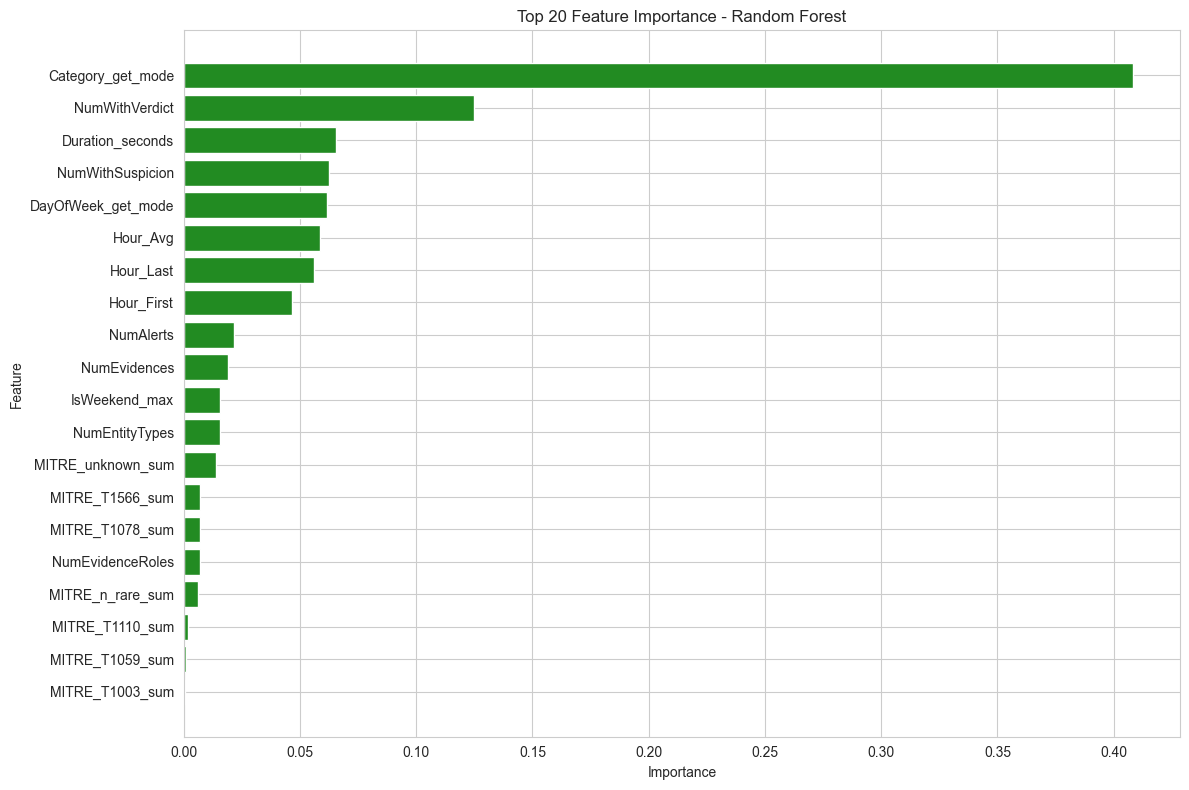

In [13]:
# Plot top features
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'], color='forestgreen')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Salvataggio Modello

In [15]:
# Crea cartella per Random Forest
model_dir = '../models/random_forest'
os.makedirs(model_dir, exist_ok=True)

# Salva modello
with open(f'{model_dir}/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Salva label encoder
with open(f'{model_dir}/label_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)

# Salva feature importance
feature_importance.to_csv(f'{model_dir}/feature_importance.csv', index=False)

# Salva metriche (inclusa ROC AUC)
metrics = {
    'model_name': 'Random Forest',
    'timestamp': datetime.now().isoformat(),
    'test_accuracy': float(accuracy),
    'test_macro_f1': float(macro_f1),
    'cv_macro_f1_mean': float(cv_scores.mean()),
    'cv_macro_f1_std': float(cv_scores.std()),
    'roc_auc_per_class': {le_target.classes_[i]: float(roc_auc[i]) for i in range(n_classes)},
    'roc_auc_micro': float(roc_auc['micro']),
    'n_features': int(X_train.shape[1]),
    'n_train_samples': int(len(X_train)),
    'n_test_samples': int(len(X_test)),
    'hyperparameters': {
        'n_estimators': model.n_estimators,
        'max_depth': model.max_depth,
        'min_samples_split': model.min_samples_split,
        'min_samples_leaf': model.min_samples_leaf,
        'max_features': model.max_features,
        'class_weight': 'balanced'
    }
}

with open(f'{model_dir}/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Modello salvato in {model_dir}/")
print("  - model.pkl")
print("  - label_encoder.pkl")
print("  - feature_importance.csv")
print("  - metrics.json")


Modello salvato in ../models/random_forest/
  - model.pkl
  - label_encoder.pkl
  - feature_importance.csv
  - metrics.json
